### metadata가 있는거랑 없는걸로 lightgbm로 비교

In [32]:
# LightGBM with and without metadata features
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [33]:
# 1. Load Data
df = pd.read_csv("../data/url_metadata_cleaned.csv")  # ファイルパスを適宜変更してください

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371357 entries, 0 to 371356
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   url                   371357 non-null  object 
 1   url_type              371357 non-null  int64  
 2   url_len               371357 non-null  int64  
 3   letters_count         371357 non-null  int64  
 4   digits_count          371357 non-null  int64  
 5   special_chars_count   371357 non-null  int64  
 6   shortened             371357 non-null  int64  
 7   is_domain_in_url      371357 non-null  int64  
 8   secure_http           371357 non-null  int64  
 9   have_ip               371357 non-null  bool   
 10  url_region            371357 non-null  object 
 11  root_domain           371227 non-null  object 
 12  redirect_count        371357 non-null  int64  
 13  timeout               371357 non-null  bool   
 14  has_meta_refresh      371357 non-null  bool   
 15  

In [35]:
# 2. Metadata feature list
metadata_features = [
    'redirect_count','timeout','duration_sec','meta_count', 'link_count', 'title_count', 'has_meta_refresh',
    'has_title', 'has_meta_description', 'has_og_image',
    'has_og_title', 'has_link_stylesheet'
]

target_col = "url_type"

In [36]:
# 3. Prepare feature sets
X_full = df.drop(columns=["url", "url_type", "root_domain", "url_region"])  # text系特徴除外
y = df[target_col]

X_no_meta = X_full.drop(columns=metadata_features)

In [37]:

# 4. Train/test split
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)
X_train_no_meta, X_test_no_meta, _, _ = train_test_split(X_no_meta, y, test_size=0.2, random_state=42)

In [38]:

# 5. Train models
def train_lgbm(X_train, y_train):
    model = lgb.LGBMClassifier(random_state=42)
    model.fit(X_train, y_train)
    return model

model_with_meta = train_lgbm(X_train_full, y_train)
model_without_meta = train_lgbm(X_train_no_meta, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1388
[LightGBM] [Info] Number of data points in the train set: 297085, number of used features: 19
[LightGBM] [Info] Start training from score -0.292332
[LightGBM] [Info] Start training from score -2.159777
[LightGBM] [Info] Start training from score -2.079620
[LightGBM] [Info] Start training from score -4.331248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 297085, number of used features: 8
[LightGBM] [Info] Start training from score -0.292332
[LightGBM] [Info] Start 

In [39]:

# 6. Evaluation
def evaluate(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    print(f"\nClassification Report ({title})")
    print(classification_report(y_test, y_pred))
    return report

report_with_meta = evaluate(model_with_meta, X_test_full, y_test, "With Metadata")
report_without_meta = evaluate(model_without_meta, X_test_no_meta, y_test, "Without Metadata")



Classification Report (With Metadata)
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     55437
           1       0.90      0.98      0.94      8512
           2       0.83      0.42      0.55      9333
           3       0.93      0.79      0.85       990

    accuracy                           0.91     74272
   macro avg       0.89      0.79      0.82     74272
weighted avg       0.90      0.91      0.90     74272


Classification Report (Without Metadata)
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     55437
           1       0.84      0.90      0.87      8512
           2       0.84      0.25      0.39      9333
           3       0.92      0.68      0.78       990

    accuracy                           0.88     74272
   macro avg       0.87      0.70      0.74     74272
weighted avg       0.87      0.88      0.85     74272



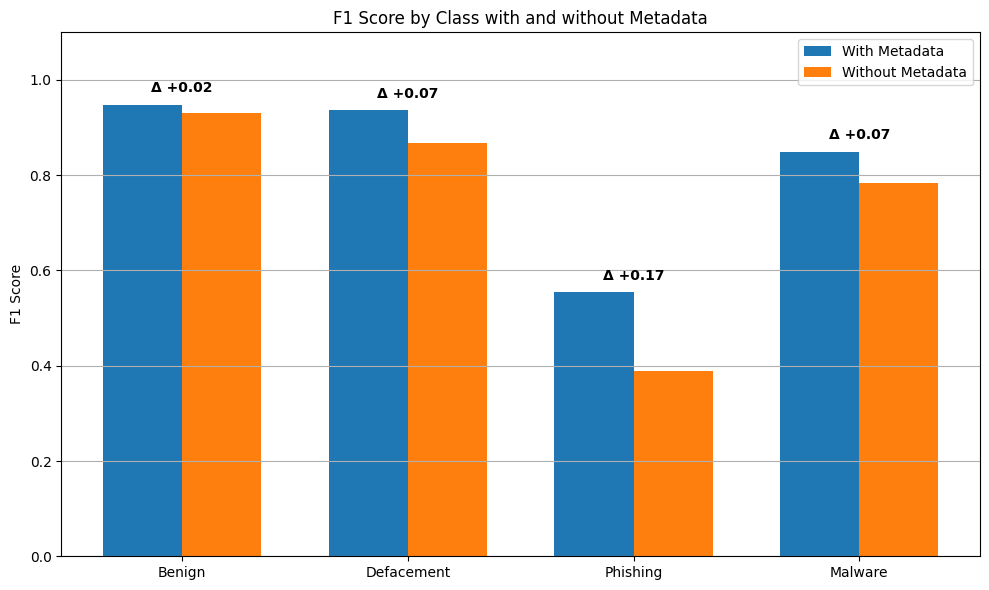

In [40]:
# 7. Visualization (差分を棒上に数値表示)
def plot_f1_scores(report_with, report_without):
    import matplotlib.pyplot as plt
    import numpy as np

    # 表示ラベルと対応クラスID
    class_labels = {
        "0": "Benign",
        "1": "Defacement",
        "2": "Phishing",
        "3": "Malware"
    }

    labels = list(class_labels.keys())
    display_labels = [class_labels[k] for k in labels]

    f1_with = [report_with[l]['f1-score'] for l in labels]
    f1_without = [report_without[l]['f1-score'] for l in labels]
    diff = [round(w - wo, 2) for w, wo in zip(f1_with, f1_without)]

    x = np.arange(len(labels))
    bar_width = 0.35

    plt.figure(figsize=(10, 6))
    bars_with = plt.bar(x - bar_width/2, f1_with, width=bar_width, label='With Metadata')
    bars_without = plt.bar(x + bar_width/2, f1_without, width=bar_width, label='Without Metadata')

    # 差分テキストを追加
    for i in range(len(x)):
        # 差分位置は両方の高さのうち高い方に表示
        y_pos = max(f1_with[i], f1_without[i]) + 0.02
        plt.text(x[i], y_pos, f"Δ {diff[i]:+.2f}", ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

    plt.xticks(x, display_labels)
    plt.ylabel("F1 Score")
    plt.title("F1 Score by Class with and without Metadata")
    plt.ylim(0, 1.1)
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


plot_f1_scores(report_with_meta, report_without_meta)


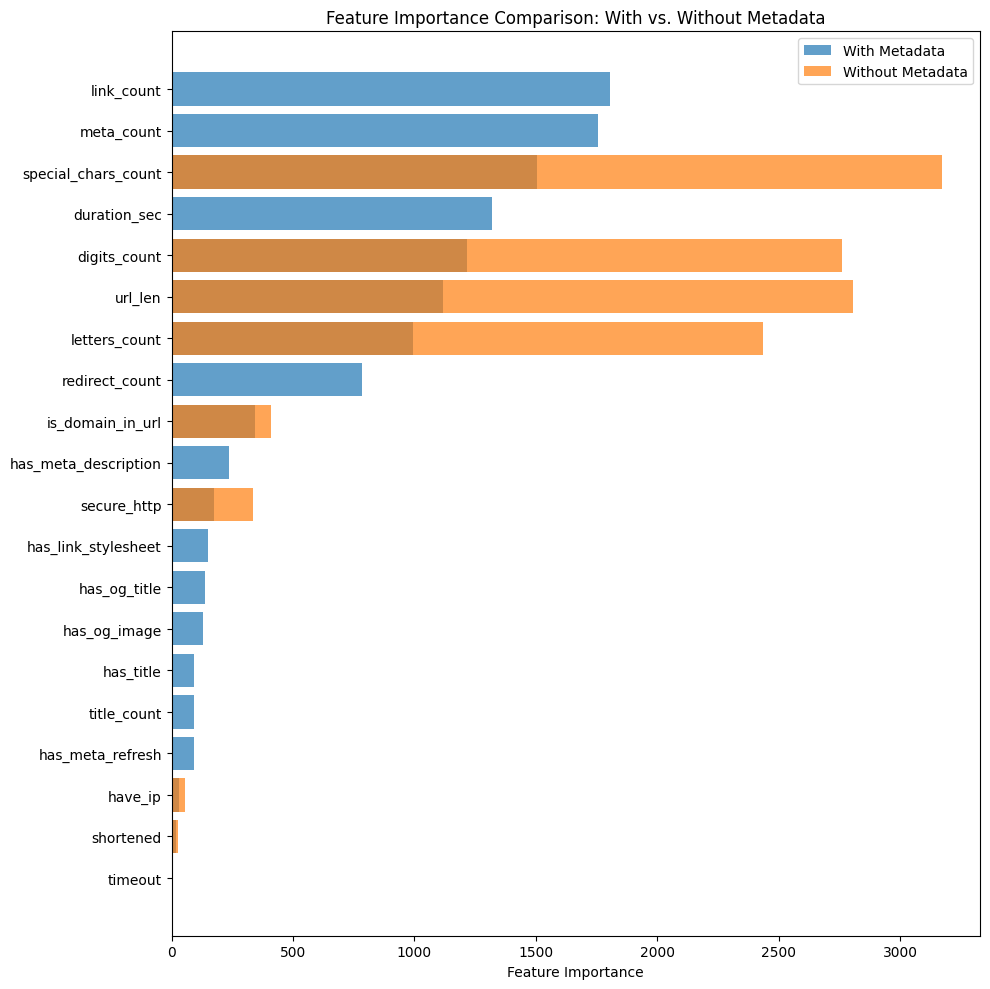

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# 特徴名と重要度
feature_names = model_with_meta.feature_name_
importance_with = model_with_meta.feature_importances_
importance_without = model_without_meta.feature_importances_

# 欠損する特徴（metadata）は0を補う
from collections import defaultdict

imp_with = defaultdict(int, zip(feature_names, importance_with))
imp_without = defaultdict(int, zip(model_without_meta.feature_name_, importance_without))

# 全特徴を統一リストで管理
all_features = sorted(set(imp_with.keys()) | set(imp_without.keys()))

# データ整形
importance_df = pd.DataFrame({
    "feature": all_features,
    "With_Metadata": [imp_with[f] for f in all_features],
    "Without_Metadata": [imp_without[f] for f in all_features],
})
importance_df["Delta"] = importance_df["With_Metadata"] - importance_df["Without_Metadata"]
importance_df = importance_df.sort_values("With_Metadata", ascending=True)

# 可視化
plt.figure(figsize=(10, 10))
plt.barh(importance_df["feature"], importance_df["With_Metadata"], label="With Metadata", alpha=0.7)
plt.barh(importance_df["feature"], importance_df["Without_Metadata"], label="Without Metadata", alpha=0.7)
plt.xlabel("Feature Importance")
plt.title("Feature Importance Comparison: With vs. Without Metadata")
plt.legend()
plt.tight_layout()
plt.show()